# neural network（神经网络）

使用逻辑回归识别手写数字。

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.io import loadmat
from sklearn.metrics import classification_report

## 训练集
一共5000个训练数据，每个数据是一个表示20乘20的灰度图像即400维，总的矩阵为5000乘400。

In [3]:
def load_data(path, transpose=True):
    data = loadmat(path)
    X = data['X']
    y = data['y']
    y = y.reshape(y.shape[0])
    print(type(X))
    if transpose:
        X = np.array([im.reshape((20,20)).T.reshape(400) for im in X])
    return X, y

In [4]:
raw_x, raw_y = load_data('ex3data1.mat')
raw_x.shape, raw_y.shape

<class 'numpy.ndarray'>


((5000, 400), (5000,))

In [5]:
def plot_an_image(image):
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.matshow(image.reshape((20,20)), cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.show()

3010


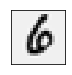

this should be 6


In [6]:
pick_one = np.random.randint(0, 5000)
print(pick_one)
plot_an_image(raw_x[pick_one, :])
print('this should be {}'.format(raw_y[pick_one]))

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

## 准备数据

![](img/向量化标签.png)

In [8]:
X = np.insert(raw_x, 0, np.ones(raw_x.shape[0]), axis=1)
X.shape

(5000, 401)

In [9]:
y = []
for k in range(1, 11):
    y.append([1 if i==k else 0 for i in raw_y])
y = np.array([y[-1]] + y[:-1])
y.shape

(10, 5000)

In [11]:
y

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1]])

## 代价函数
![](img/cost.png)

In [10]:
def cost(theta, X, y):
    first = y * np.log(sigmoid(X @ theta.T))
    second = (1 - y) * np.log(1 - sigmoid(X @ theta.T))
    return -np.mean(first + second)

In [11]:
def regularized_cost(theta, X, y, l):
    reg = l / (2 * len(X)) * (theta[1:] ** 2).sum()
    return cost(theta, X, y) + reg

## 梯度函数
![](img/gradient.png)


In [12]:
def gradient(theta, X, y, l):
    error = sigmoid(X@theta.T) - y
    grad = X.T @ error / len(X)
    reg = theta * l / len(X)
    reg[0] = 0
    return grad + reg

In [13]:
def logistic_regression(X, y, l=1):
    theta = np.zeros(X.shape[1])
    res = opt.minimize(fun = regularized_cost, x0=theta, args=(X, y, l), method='TNC', jac=gradient, options={'disp': True})
    return res.x

## 预测分析

In [14]:
def predict(theta, X):
    prob = sigmoid(X @ theta)
    return [1 if i >= 0.5 else 0 for i in prob]

训练1维

In [15]:
theta_0 = logistic_regression(X, y[0])
theta_0.shape

(401,)

In [16]:
y_pred = predict(theta_0, X)
print('Accurary = {}'.format(np.mean(y[0] == y_pred)))

Accurary = 0.9974


训练k维

In [17]:
theta_k = np.array([logistic_regression(X, y[k]) for k in range(10)])
theta_k.shape

(10, 401)

X：(5000, 401)

y：(10, 5000)

theta_k：(10,401)

In [18]:
prob_matrix = sigmoid(X @ theta_k.T)
np.set_printoptions(suppress=True)#不需要以科学计数法进行输出
prob_matrix

array([[0.99577396, 0.        , 0.00053364, ..., 0.00006469, 0.00003904,
        0.00171709],
       [0.99834687, 0.0000001 , 0.00005602, ..., 0.00009679, 0.0000029 ,
        0.00008478],
       [0.99140084, 0.        , 0.00056919, ..., 0.00000654, 0.02653221,
        0.0019758 ],
       ...,
       [0.00000068, 0.04139908, 0.00320838, ..., 0.00012723, 0.00297294,
        0.70789152],
       [0.00001843, 0.00000013, 0.00000009, ..., 0.00164835, 0.06816915,
        0.8609958 ],
       [0.02881654, 0.        , 0.00012967, ..., 0.36605901, 0.00497141,
        0.14807259]])

In [19]:
y_pred = np.argmax(prob_matrix, axis=1) # 返回每行最大的列索引
y_pred = np.array([10 if i == 0 else i for i in y_pred])
y_pred

array([10, 10, 10, ...,  9,  9,  7], dtype=int64)

In [20]:
print(classification_report(raw_y, y_pred))

              precision    recall  f1-score   support

           1       0.95      0.99      0.97       500
           2       0.95      0.92      0.93       500
           3       0.95      0.91      0.93       500
           4       0.95      0.95      0.95       500
           5       0.92      0.92      0.92       500
           6       0.97      0.98      0.97       500
           7       0.95      0.95      0.95       500
           8       0.93      0.92      0.92       500
           9       0.92      0.92      0.92       500
          10       0.97      0.99      0.98       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



# 神经网络

![](img/nn_model.png)

## 前向传播

已经给出训练得到的theta1,theta2，通过前向传播计算得到预测结果

In [21]:
def load_weight(path):
    data = loadmat(path)
    return data['Theta1'], data['Theta2']

In [22]:
theta1, theta2 = load_weight('ex3weights.mat')
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [23]:
X, y = load_data('ex3data1.mat', transpose=False)
X = np.insert(X, 0, np.ones(X.shape[0]), axis=1)
X.shape, y.shape

<class 'numpy.ndarray'>


((5000, 401), (5000,))

输入层

In [24]:
a1 = X

In [25]:
z2 = a1 @ theta1.T
z2 = np.insert(z2, 0, np.ones(z2.shape[0]), axis=1)
z2.shape

(5000, 26)

第二层

In [26]:
a2 = sigmoid(z2)
a2.shape

(5000, 26)

In [27]:
z3 = a2 @ theta2.T
z3.shape

(5000, 10)

输出层

In [28]:
a3 = sigmoid(z3)
a3.shape

(5000, 10)

In [29]:
a3

array([[0.00013825, 0.0020554 , 0.00304012, ..., 0.00049102, 0.00774326,
        0.99622946],
       [0.00058776, 0.00285027, 0.00414688, ..., 0.00292311, 0.00235617,
        0.99619667],
       [0.00010868, 0.0038266 , 0.03058551, ..., 0.07514539, 0.0065704 ,
        0.93586278],
       ...,
       [0.06278247, 0.00450406, 0.03545109, ..., 0.0026367 , 0.68944816,
        0.00002744],
       [0.00101909, 0.00073436, 0.00037856, ..., 0.01456166, 0.97598976,
        0.00023337],
       [0.00005908, 0.00054172, 0.0000259 , ..., 0.00700508, 0.73281465,
        0.09166961]])

In [30]:
y_pred = np.argmax(a3, axis=1)+1
y_pred

array([10, 10, 10, ...,  9,  9,  9], dtype=int64)

In [31]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.97      0.98      0.97       500
           2       0.98      0.97      0.97       500
           3       0.98      0.96      0.97       500
           4       0.97      0.97      0.97       500
           5       0.98      0.98      0.98       500
           6       0.97      0.99      0.98       500
           7       0.98      0.97      0.97       500
           8       0.98      0.98      0.98       500
           9       0.97      0.96      0.96       500
          10       0.98      0.99      0.99       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

